In [1]:
using Pkg
Pkg.activate("./")
#Pkg.instantiate()

  Activating project at `~/Documents/UCL/3x2_analytical`


In [2]:
using LinearAlgebra
using ForwardDiff
using Plots
using LimberJack
using CSV
using YAML
using NPZ
using DataFrames
using PythonCall
sacc = pyimport("sacc");

# Judith's Chain

In [3]:
#using DelimitedFiles
#chain = readdlm("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/cosmodc2_3x2pt_fourier_lcdm.txt");

In [4]:
#chain_vals = chain[200:end, :]
#param_names = chain[1, :];

#post = chain_vals[:, 32]
#index_of_min = argmax(post)
#row_with_min = chain_vals[index_of_min, :]
#Wm = row_with_min[1]+row_with_min[2]
#Wb = row_with_min[2]
#h0 = row_with_min[5]
#ns = row_with_min[3]
#s8 = row_with_min[29]
#best_params = [Wm, Wb, h0, s8, ns]
#print(best_params)

#nuisances = Dict(
#    "lens_0_b" => row_with_min[13],
#    "lens_1_b" => row_with_min[14],
#    "lens_2_b" => row_with_min[15],
#    "lens_3_b" => row_with_min[16],
#    "lens_4_b" => row_with_min[17],
#    "source_0_m" => row_with_min[8],
#    "source_1_m" => row_with_min[9],
#    "source_2_m" => row_with_min[10],
#    "source_3_m" => row_with_min[11],
#    "source_4_m" => row_with_min[12])

In [5]:
function make_Cmod(dz_mean, dz_cov, data_cov, model; mode="AD")
    m = size(dz_cov)[1]
    n_cls = size(data_cov)[1]
    T = zeros(n_cls, m)

    if mode == "AD"
        println("Using automatic differentiation to compute T")
        T = ForwardDiff.jacobian(model, dz_mean)
    elseif mode == "FD"
        println("Using finite differences to compute T")
        d = 0.05
        for i in 1:m
            e = zeros(m)
            e[i] = d
            T[:, i] = (model(dz_mean.+e) .- model(dz_mean.-e)) ./ (2*d)
        end
    end
    TPT = T * dz_cov * T'
    Cmod = Symmetric(data_cov + TPT)
    return Cmod
end

make_Cmod (generic function with 1 method)

In [6]:
#dz_err_wlwl = [0.017, 0.017, 0.013, 0.015]
#dz_err_gcgc = [0.007, 0.007, 0.006, 0.01, 0.01]
#dz_err_3x2 = [dz_err_wlwl; dz_err_gcgc]

#dz_cov_wlwl = diagm(dz_err_wlwl.^2)
#dz_cov_gcgc = diagm(dz_err_gcgc.^2)
#dz_cov_3x2 = diagm(dz_err_3x2.^2);

## WLWL

In [7]:

method = "bpz"
sacc_path = "./data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "./data/CosmoDC2/wlwl.yml"
nz_path = string("./data/CosmoDC2/image_nzs_", method, "_priors/")
dz_path = string("./data/CosmoDC2/image_dz_", method, "_priors/dz_prior.npz")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["dndz"]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["dndz"]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["dndz"]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["dndz"]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")
zs_k5, nz_k5 = LimberJack.nz_interpolate(zs_k5, nz_k5, 1000; mode="cubic")
zs_k6, nz_k6 = LimberJack.nz_interpolate(zs_k6, nz_k6, 1000; mode="cubic")
zs_k7, nz_k7 = LimberJack.nz_interpolate(zs_k7, nz_k7, 1000; mode="cubic")
zs_k8, nz_k8 = LimberJack.nz_interpolate(zs_k8, nz_k8, 1000; mode="cubic")
zs_k9, nz_k9 = LimberJack.nz_interpolate(zs_k9, nz_k9, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)
nz_source_0 = Dict("z"=>zs_k5, "dndz"=>nz_k5)
nz_source_1 = Dict("z"=>zs_k6, "dndz"=>nz_k6)
nz_source_2 = Dict("z"=>zs_k7, "dndz"=>nz_k7)
nz_source_3 = Dict("z"=>zs_k8, "dndz"=>nz_k8)
nz_source_4 = Dict("z"=>zs_k9, "dndz"=>nz_k9)

mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)
mu_k5 = sum(zs_k5 .* nz_k5) / sum(nz_k5)
mu_k6 = sum(zs_k6 .* nz_k6) / sum(nz_k6)
mu_k7 = sum(zs_k7 .* nz_k7) / sum(nz_k7)
mu_k8 = sum(zs_k8 .* nz_k8) / sum(nz_k8)
mu_k9 = sum(zs_k9 .* nz_k9) / sum(nz_k9)

dz_prior = npzread(dz_path)
dz_mean_wlwl, dz_cov_wlwl = dz_prior["mean"], dz_prior["cov"]
dz_mean_wlwl = dz_mean_wlwl[1:5]
dz_cov_wlwl = dz_cov_wlwl[1:5, 1:5]
dz_chol_wlwl = cholesky(dz_cov_wlwl).U'

meta_wlwl, files_wlwl = make_data(sacc_file, yaml_file;
                        nz_source_0=nz_source_0,
                        nz_source_1=nz_source_1,
                        nz_source_2=nz_source_2,
                        nz_source_3=nz_source_3,
                        nz_source_4=nz_source_4)

meta_wlwl.types = [    
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

source_0 source_0 13
source_1 source_0 13
source_1 source_1 13
source_2 source_0 13
source_2 source_1 13
source_2 source_2 13
source_3 source_0 13
source_3 source_1 13
source_3 source_2 13
source_3 source_3 13
source_4 source_0 13
source_4 source_1 13
source_4 source_2 13
source_4 source_3 13
source_4 source_4 13
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_source_4


5-element Vector{String}:
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

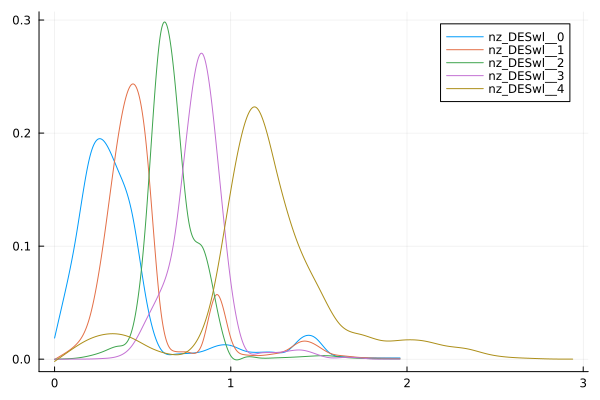

In [8]:
plot(files_wlwl["nz_source_0"][1], files_wlwl["nz_source_0"][2], label="nz_DESwl__0")
plot!(files_wlwl["nz_source_1"][1], files_wlwl["nz_source_1"][2], label="nz_DESwl__1")
plot!(files_wlwl["nz_source_2"][1], files_wlwl["nz_source_2"][2], label="nz_DESwl__2")
plot!(files_wlwl["nz_source_3"][1], files_wlwl["nz_source_3"][2], label="nz_DESwl__3")
plot!(files_wlwl["nz_source_4"][1], files_wlwl["nz_source_4"][2], label="nz_DESwl__4")

In [9]:
function model_wlwl(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_1_b=0.879118, lens_2_b=1.05894, lens_3_b=1.22145, lens_4_b=1.35065, lens_5_b=1.58909,
    A_IA=0.25179439,
    meta=meta_wlwl, files=files_wlwl)

    dzs = dz_mean_wlwl .+ dz_chol_wlwl * alphas
    source_0_zs = zs_k5 .+ dzs[1]
    source_1_zs = zs_k6 .+ dzs[2]
    source_2_zs = zs_k7 .+ dzs[3]
    source_3_zs = zs_k8 .+ dzs[4]
    source_4_zs = zs_k9 .+ dzs[5]

    nuisances = Dict(
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_5_b"    => lens_5_b,
        "source_0_zs" => source_0_zs,
        "source_1_zs" => source_1_zs,
        "source_2_zs" => source_2_zs,
        "source_3_zs" => source_3_zs,
        "source_4_zs" => source_4_zs,
        "A_IA"        => A_IA)
        
        cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
            tk_mode=:EisHu,
            pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [10]:
Cmod_wlwl_FD = make_Cmod(dz_mean_wlwl, diagm(ones(5)), meta_wlwl.cov, model_wlwl; mode="FD")
Cmod_wlwl_AD = make_Cmod(dz_mean_wlwl, diagm(ones(5)), meta_wlwl.cov, model_wlwl; mode="AD")

Using finite differences to compute T
Using automatic differentiation to compute T


195×195 Symmetric{Float64, Matrix{Float64}}:
  1.95322e-17  -1.97872e-18   9.291e-19    …  -1.28372e-21  -8.79229e-22
 -1.97872e-18   4.98453e-18  -1.17736e-19     -8.78645e-22  -6.01851e-22
  9.291e-19    -1.17736e-19   1.73645e-18     -5.8381e-22   -3.99937e-22
  3.60756e-19   3.08754e-19   4.68263e-20     -3.77042e-22  -2.58325e-22
  2.52832e-19   1.69752e-19   1.22201e-19     -2.43551e-22  -1.66883e-22
  1.65668e-19   1.14179e-19   7.52156e-20  …  -1.61088e-22  -1.10388e-22
  1.12234e-19   7.70599e-20   5.12035e-20     -1.08998e-22  -7.46972e-23
  7.74301e-20   5.31326e-20   3.53208e-20     -7.52263e-23  -5.15543e-23
  5.37918e-20   3.6895e-20    2.4535e-20      -5.22615e-23  -3.58158e-23
  3.70063e-20   2.5379e-20    1.68795e-20     -3.59515e-23  -2.46387e-23
  2.4743e-20    1.69694e-20   1.12874e-20  …  -2.40856e-23  -1.64707e-23
  1.58548e-20   1.08752e-20   7.23416e-21     -1.43551e-23  -1.05603e-23
  9.69061e-21   6.64919e-21   4.42316e-21     -9.41665e-24  -6.23087e-24
  ⋮   

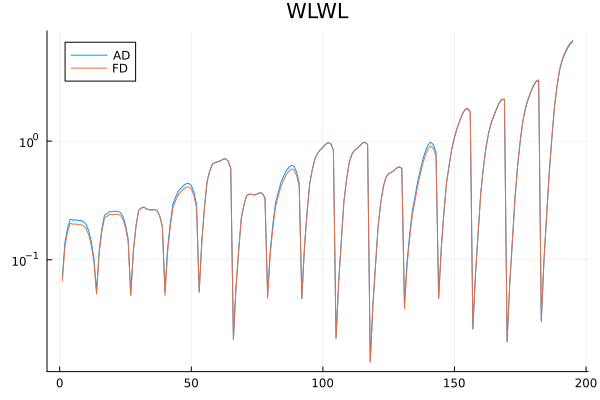

In [11]:
plot(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_AD)) ./ diag(meta_wlwl.cov), label="AD", title="WLWL")
plot!(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_FD)) ./ diag(meta_wlwl.cov), yscale=:log10, label="FD", title="WLWL")

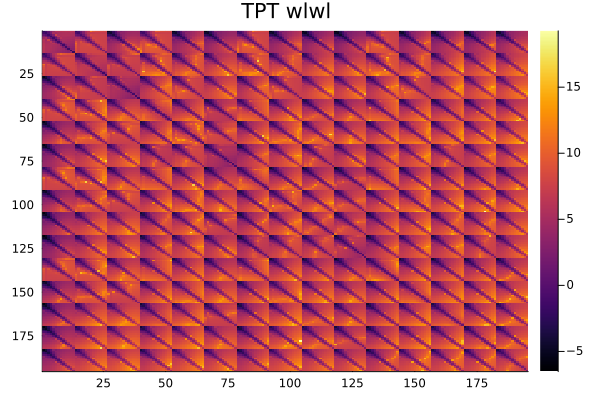

In [12]:
heatmap(log.(abs.((Cmod_wlwl_AD .- meta_wlwl.cov)./ meta_wlwl.cov)), title="TPT wlwl", yflip=true)

## GCGC

In [13]:
method = "bpz"
sacc_path = "data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "data/CosmoDC2/gcgc.yml"
nz_path = string("data/CosmoDC2/image_nzs_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["dndz"]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["dndz"]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["dndz"]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["dndz"]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")
zs_k5, nz_k5 = LimberJack.nz_interpolate(zs_k5, nz_k5, 1000; mode="cubic")
zs_k6, nz_k6 = LimberJack.nz_interpolate(zs_k6, nz_k6, 1000; mode="cubic")
zs_k7, nz_k7 = LimberJack.nz_interpolate(zs_k7, nz_k7, 1000; mode="cubic")
zs_k8, nz_k8 = LimberJack.nz_interpolate(zs_k8, nz_k8, 1000; mode="cubic")
zs_k9, nz_k9 = LimberJack.nz_interpolate(zs_k9, nz_k9, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)
nz_source_0 = Dict("z"=>zs_k5, "dndz"=>nz_k5)
nz_source_1 = Dict("z"=>zs_k6, "dndz"=>nz_k6)
nz_source_2 = Dict("z"=>zs_k7, "dndz"=>nz_k7)
nz_source_3 = Dict("z"=>zs_k8, "dndz"=>nz_k8)
nz_source_4 = Dict("z"=>zs_k9, "dndz"=>nz_k9)

mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)
mu_k5 = sum(zs_k5 .* nz_k5) / sum(nz_k5)
mu_k6 = sum(zs_k6 .* nz_k6) / sum(nz_k6)
mu_k7 = sum(zs_k7 .* nz_k7) / sum(nz_k7)
mu_k8 = sum(zs_k8 .* nz_k8) / sum(nz_k8)
mu_k9 = sum(zs_k9 .* nz_k9) / sum(nz_k9)

dz_prior = npzread(dz_path)
dz_mean_gcgc, dz_cov_gcgc = dz_prior["mean"], dz_prior["cov"]
dz_mean_gcgc = dz_mean_gcgc[6:end]
dz_cov_gcgc = dz_cov_gcgc[6:end, 6:end]
dz_chol_gcgc = cholesky(dz_cov_gcgc).U'

meta_gcgc, files_gcgc = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4)

meta_gcgc.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density"]


lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


5-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"

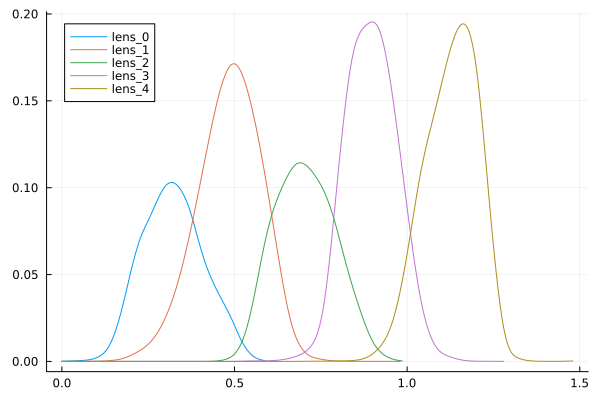

In [14]:
plot(files_gcgc["nz_lens_0"][1], files_gcgc["nz_lens_0"][2], label="lens_0")
plot!(files_gcgc["nz_lens_1"][1], files_gcgc["nz_lens_1"][2], label="lens_1")
plot!(files_gcgc["nz_lens_2"][1], files_gcgc["nz_lens_2"][2], label="lens_2")
plot!(files_gcgc["nz_lens_3"][1], files_gcgc["nz_lens_3"][2], label="lens_3")
plot!(files_gcgc["nz_lens_4"][1], files_gcgc["nz_lens_4"][2], label="lens_4")

In [15]:
function model_gcgc(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_1_b=0.879118, lens_2_b=1.05894, lens_3_b=1.22145, lens_4_b=1.35065, lens_5_b=1.58909,
    A_IA=0.25179439,
    meta=meta_gcgc, files=files_gcgc)

    dzs = dz_mean_gcgc .+ dz_chol_gcgc * alphas
    wzs = ones(5)
    lens_0_zs = @.((zs_k0-mu_k0)/wzs[1] + mu_k0 + dzs[1])
    lens_1_zs = @.((zs_k1-mu_k1)/wzs[2] + mu_k1 + dzs[2])
    lens_2_zs = @.((zs_k2-mu_k2)/wzs[3] + mu_k2 + dzs[3])
    lens_3_zs = @.((zs_k3-mu_k3)/wzs[4] + mu_k3 + dzs[4])
    lens_4_zs = @.((zs_k4-mu_k4)/wzs[5] + mu_k4 + dzs[5])
    
    nuisances = Dict(
    "lens_1_b"    => lens_1_b,
    "lens_2_b"    => lens_2_b,
    "lens_3_b"    => lens_3_b,
    "lens_4_b"    => lens_4_b,
    "lens_5_b"    => lens_5_b,
    "lens_0_zs"   => lens_0_zs,
    "lens_1_zs"   => lens_1_zs,
    "lens_2_zs"   => lens_2_zs,
    "lens_3_zs"   => lens_3_zs,
    "lens_4_zs"   => lens_4_zs,
    "A_IA"        => A_IA)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [16]:
println(size(dz_mean_gcgc))
println(size(dz_cov_gcgc))
println(size(meta_gcgc.cov))

(5,)
(5, 5)
(39, 39)


In [17]:
Cmod_gcgc_FD = make_Cmod(dz_mean_gcgc, diagm(ones(5)), meta_gcgc.cov, model_gcgc; mode="FD")
Cmod_gcgc_AD = make_Cmod(dz_mean_gcgc, diagm(ones(5)), meta_gcgc.cov, model_gcgc; mode="AD");

Using finite differences to compute T
Using automatic differentiation to compute T


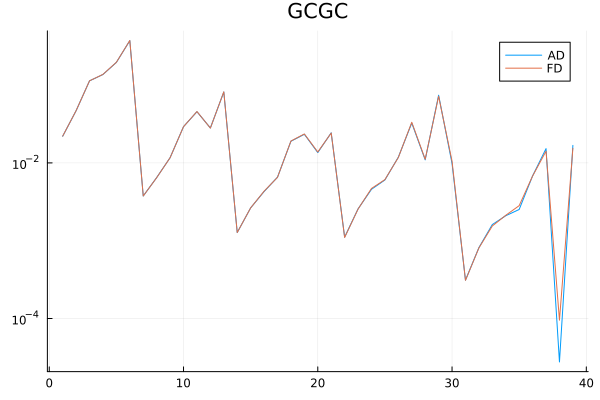

In [18]:
plot(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_AD)) ./ diag(meta_gcgc.cov), label="AD", title="GCGC")
plot!(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_FD)) ./ diag(meta_gcgc.cov), yscale=:log10, label="FD")

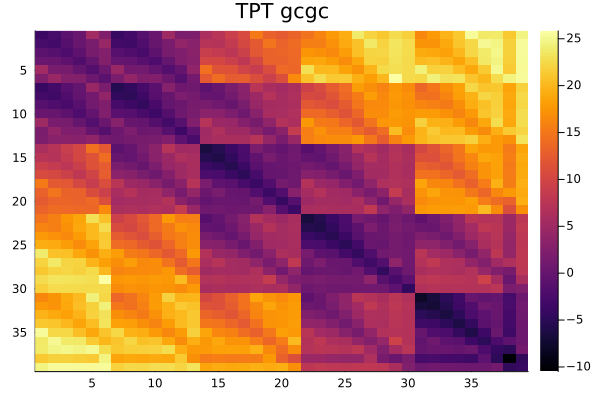

In [19]:
heatmap(log.(abs.((Cmod_gcgc_AD .- meta_gcgc.cov)./ meta_gcgc.cov)), title="TPT gcgc", yflip=true)

## 3x2

In [20]:
method = "bpz"
sacc_path = "data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "data/CosmoDC2/gcgc_gcwl_wlwl.yml"
nz_path = string("data/CosmoDC2/image_nzs_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["dndz"]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["dndz"]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["dndz"]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["dndz"]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")
zs_k5, nz_k5 = LimberJack.nz_interpolate(zs_k5, nz_k5, 1000; mode="cubic")
zs_k6, nz_k6 = LimberJack.nz_interpolate(zs_k6, nz_k6, 1000; mode="cubic")
zs_k7, nz_k7 = LimberJack.nz_interpolate(zs_k7, nz_k7, 1000; mode="cubic")
zs_k8, nz_k8 = LimberJack.nz_interpolate(zs_k8, nz_k8, 1000; mode="cubic")
zs_k9, nz_k9 = LimberJack.nz_interpolate(zs_k9, nz_k9, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)
nz_source_0 = Dict("z"=>zs_k5, "dndz"=>nz_k5)
nz_source_1 = Dict("z"=>zs_k6, "dndz"=>nz_k6)
nz_source_2 = Dict("z"=>zs_k7, "dndz"=>nz_k7)
nz_source_3 = Dict("z"=>zs_k8, "dndz"=>nz_k8)
nz_source_4 = Dict("z"=>zs_k9, "dndz"=>nz_k9)

mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)
mu_k5 = sum(zs_k5 .* nz_k5) / sum(nz_k5)
mu_k6 = sum(zs_k6 .* nz_k6) / sum(nz_k6)
mu_k7 = sum(zs_k7 .* nz_k7) / sum(nz_k7)
mu_k8 = sum(zs_k8 .* nz_k8) / sum(nz_k8)
mu_k9 = sum(zs_k9 .* nz_k9) / sum(nz_k9)

dz_prior = npzread(dz_path)
dz_mean_3x2, dz_cov_3x2 = dz_prior["mean"], dz_prior["cov"]
dz_chol_3x2 = cholesky(dz_cov_3x2).U'

meta_3x2, files_3x2 = make_data(sacc_file, yaml_file;
    nz_lens_0=nz_lens_0,
    nz_lens_1=nz_lens_1,
    nz_lens_2=nz_lens_2,
    nz_lens_3=nz_lens_3,
    nz_lens_4=nz_lens_4,
    nz_source_0=nz_source_0,
    nz_source_1=nz_source_1,
    nz_source_2=nz_source_2,
    nz_source_3=nz_source_3,
    nz_source_4=nz_source_4)


meta_3x2.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
source_0 lens_0 6
source_0 lens_1 7
source_0 lens_2 8
source_0 lens_3 9
source_0 lens_4 9
source_1 lens_0 8
source_1 lens_1 7
source_1 lens_2 8
source_1 lens_3 9
source_1 lens_4 9
source_2 lens_0 8
source_2 lens_1 7
source_2 lens_2 8
source_2 lens_3 9
source_2 lens_4 9
source_3 lens_0 8
source_3 lens_1 7
source_3 lens_2 8
source_3 lens_3 9
source_3 lens_4 9
source_4 lens_0 8
source_4 lens_1 7
source_4 lens_2 8
source_4 lens_3 9
source_4 lens_4 9
source_0 source_0 13
source_1 source_0 13
source_1 source_1 13
source_2 source_0 13
source_2 source_1 13
source_2 source_2 13
source_3 source_0 13
source_3 source_1 13
source_3 source_2 13
source_3 source_3 13
source_4 source_0 13
source_4 source_1 13
source_4 source_2 13
source_4 source_3 13
source_4 source_4 13
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_sour

10-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

In [21]:
function model_3x2(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_1_b=0.879118, lens_2_b=1.05894, lens_3_b=1.22145, lens_4_b=1.35065, lens_5_b=1.58909,
    A_IA=0.25179439,
    meta=meta_3x2, files=files_3x2)

    dzs = dz_mean_3x2 .+ dz_chol_3x2 * alphas
    wzs = ones(10)
    lens_0_zs   = @.((zs_k0-mu_k0)/wzs[1] + mu_k0 + dzs[1])
    lens_1_zs   = @.((zs_k1-mu_k1)/wzs[2] + mu_k1 + dzs[2])
    lens_2_zs   = @.((zs_k2-mu_k2)/wzs[3] + mu_k2 + dzs[3])
    lens_3_zs   = @.((zs_k3-mu_k3)/wzs[4] + mu_k3 + dzs[4])
    lens_4_zs   = @.((zs_k4-mu_k4)/wzs[5] + mu_k4 + dzs[5])
    source_0_zs = @.((zs_k5-mu_k5)/wzs[6] + mu_k5 + dzs[6])
    source_1_zs = @.((zs_k6-mu_k6)/wzs[7] + mu_k6 + dzs[7])
    source_2_zs = @.((zs_k7-mu_k7)/wzs[8] + mu_k7 + dzs[8])
    source_3_zs = @.((zs_k8-mu_k8)/wzs[9] + mu_k8 + dzs[9])
    source_4_zs = @.((zs_k9-mu_k9)/wzs[10] + mu_k9 + dzs[10])

    nuisances = Dict(
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_5_b"    => lens_5_b,
        "lens_0_zs"   => lens_0_zs,
        "lens_1_zs"   => lens_1_zs,
        "lens_2_zs"   => lens_2_zs,
        "lens_3_zs"   => lens_3_zs,
        "lens_4_zs"   => lens_4_zs,
        "source_0_zs" => source_0_zs,
        "source_1_zs" => source_1_zs,
        "source_2_zs" => source_2_zs,
        "source_3_zs" => source_3_zs,
        "source_4_zs" => source_4_zs,
        "A_IA"        => A_IA)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [22]:
Cmod_3x2_FD = make_Cmod(dz_mean_3x2, diagm(ones(10)), meta_3x2.cov, model_3x2; mode="FD");
Cmod_3x2_AD = make_Cmod(dz_mean_3x2, diagm(ones(10)), meta_3x2.cov, model_3x2; mode="AD");

Using finite differences to compute T
Using automatic differentiation to compute T


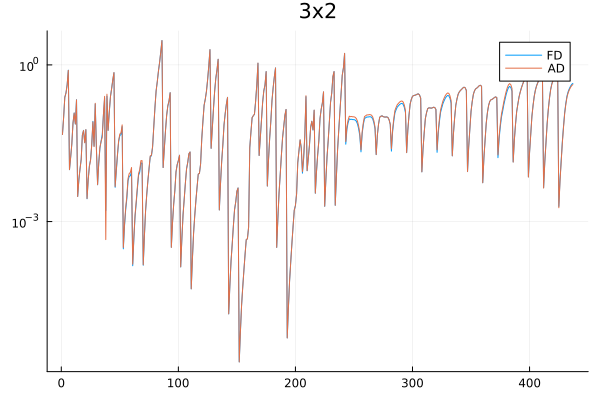

In [23]:
plot(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_FD)) ./ diag(meta_3x2.cov), label="FD", title="3x2")
plot!(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_AD)) ./ diag(meta_3x2.cov), yscale=:log10, label="AD")

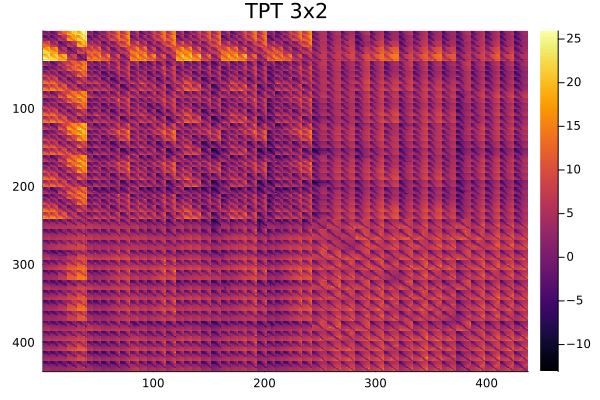

In [24]:
heatmap(log.(abs.((Cmod_3x2_AD .- meta_3x2.cov)./ meta_3x2.cov)), title="TPT 3x2", yflip=true)

## Save

In [25]:
using NPZ
npzwrite("covs/COSMODC2/dz_covs.npz",
        Dict(
        "wlwl_AD" => Cmod_wlwl_AD,
        "wlwl_FD" => Cmod_wlwl_FD,
        "gcgc_AD" => Cmod_gcgc_AD,
        "gcgc_FD" => Cmod_gcgc_FD,
        "3x2_AD" => Cmod_3x2_AD,
        "3x2_FD" => Cmod_3x2_FD))